In [1]:
import os
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from library.utils import *
from library.model import *
from library.active_learning import *
import warnings
warnings.filterwarnings("ignore")

Changing working directory if needed

In [2]:
# this function find your current working directory
os.getcwd()

# DIRECTORY = 'c:\\Users\\tnhoang\\Documents\\active_learning_cell_free\\active_learning_loop\\'
# os.chdir(DIRECTORY)

'c:\\Users\\tnhoang\\Documents\\active_learning_cell_free\\active_learning_loop'

Input: modify here

- Parameter file: must be csv, with each component as row, names in first column, then maximun concentration and different ratio in each column
- Data files must be csv, with row as experiment, each column contains concentration, target should be last 1-2 columns

In [3]:
# IMPORTANT: data input for modelling 
parameter_file = "data\\parameter_lipase_modify_name.csv"  # path\\name of parameter files
data_folder = "data\\no_controls"                          # where data files are
target = ['yield', 'yield_std']                            # column name of Y for modelling

# Modelling parameters 
nb_ensemble = 4                                            # nb of models in ensemble 
nb_repeat = 4                                              # nb of repeatition to select best initial random weight
hidden_layer_sizes = [(10, 100, 100, 20),
                    (100, 100, 20),
                    (40, 10),
                    (10)]                                  # architechture for mlp models

# active learning parameters
nb_new_data = 500                                          # nb of new data seleted every interations of active learning
visual = True
interation = 1                                             # to name result files
name = "data\\active_learning_result\\Interation_" + str(interation)        # please create in advance an 'active_learning_result' file in your directory/ or change into your desire file 

Read parameter file:
- check if component name are correct 
- verbose = False if you don't want to print out any information

In [4]:
element_list, element_max, sampling_condition = import_parameter(parameter_file, verbose = True)

Number of metabolites : 11
Number of combinations - poolsize : 4194304
Possible concentrations: 


,mg_gluta,K_gluta,aa,trna,coa,nad,camp,folinic_acid,spermidin,pga,nucleo_mix
0,0.4,8.0,0.15,0.02,0.026,0.033,0.075,0.0068,0.1,3.0,0.15
1,1.2,24.0,0.45,0.06,0.078,0.099,0.225,0.0204,0.3,9.0,0.45
2,2.0,40.0,0.75,0.10,0.130,0.165,0.375,0.0340,0.5,15.0,0.75
3,4.0,80.0,1.50,0.20,0.260,0.330,0.750,0.0680,1.0,30.0,1.50


Read all csv file in data folder, check if their column names and orders are the same, if not then skip file
 - Please check if all files you want appeared
 - Check if Y column and Y_std are the last 2 columns
 - if print out "All files have consistent column orders" => good to go

In [5]:
data = import_data(data_folder, verbose = True)

Read  10  files: 
-  plate_AL_10_raw_yield_and_std.csv
-  plate_AL_1_raw_yield_and_std.csv
-  plate_AL_2_raw_yield_and_std.csv
-  plate_AL_3_raw_yield_and_std.csv
-  plate_AL_4_raw_yield_and_std.csv
-  plate_AL_5_raw_yield_and_std.csv
-  plate_AL_6_raw_yield_and_std.csv
-  plate_AL_7_raw_yield_and_std.csv
-  plate_AL_8_raw_yield_and_std.csv
-  plate_AL_9_raw_yield_and_std.csv


,nad,folinic_acid,coa,nucleo_mix,spermidin,pga,aa,trna,mg_gluta,camp,K_gluta,yield,yield_std
0,0.165,0.0068,0.026,1.5,0.1,9,0.75,0.02,4.0,0.075,80,2.2258,0.2420
1,0.099,0.0204,0.026,1.5,0.1,9,0.75,0.06,4.0,0.075,80,2.3039,0.1469
2,0.165,0.0068,0.078,1.5,0.1,9,0.75,0.02,4.0,0.075,80,2.4212,0.0426
3,0.099,0.0204,0.026,1.5,0.1,9,0.75,0.02,4.0,0.225,80,2.3568,0.0690
4,0.033,0.0340,0.078,1.5,0.1,9,0.75,0.02,4.0,0.075,80,2.4100,0.1124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,0.033,0.0680,0.078,1.5,0.1,9,1.50,0.20,4.0,0.225,80,2.1392,0.1987
1013,0.330,0.0340,0.130,1.5,0.1,9,1.50,0.10,4.0,0.225,80,2.4856,0.1093
1014,0.330,0.0680,0.130,1.5,0.1,9,1.50,0.06,4.0,0.075,80,2.5275,0.0938
1015,0.099,0.0680,0.078,1.5,0.1,9,1.50,0.20,4.0,0.225,80,2.5409,0.1190


All files have consistent column orders.


Check column names are consitant between data files and parameter files, if not through a warning

In [6]:
check_column_names(data,target,element_list)

All column names matched!


Modelling part (to be change)

In [7]:
# Split X/y
X = data[element_list]
y = data[target[0]]

# normalize data
scaler = MinMaxScaler()
scaler.fit(X)
X_normalized = scaler.transform(X)

# train emsemble
ensemble_models = []
for i in range(nb_ensemble):
    repeat_models = train_repeat(X_normalized, y,
               hidden_layer_sizes,
               nb_repeat = nb_repeat,
               verbose = False)
    
    best_model = pick_lowest_loss(repeat_models)
    ensemble_models.append(best_model)

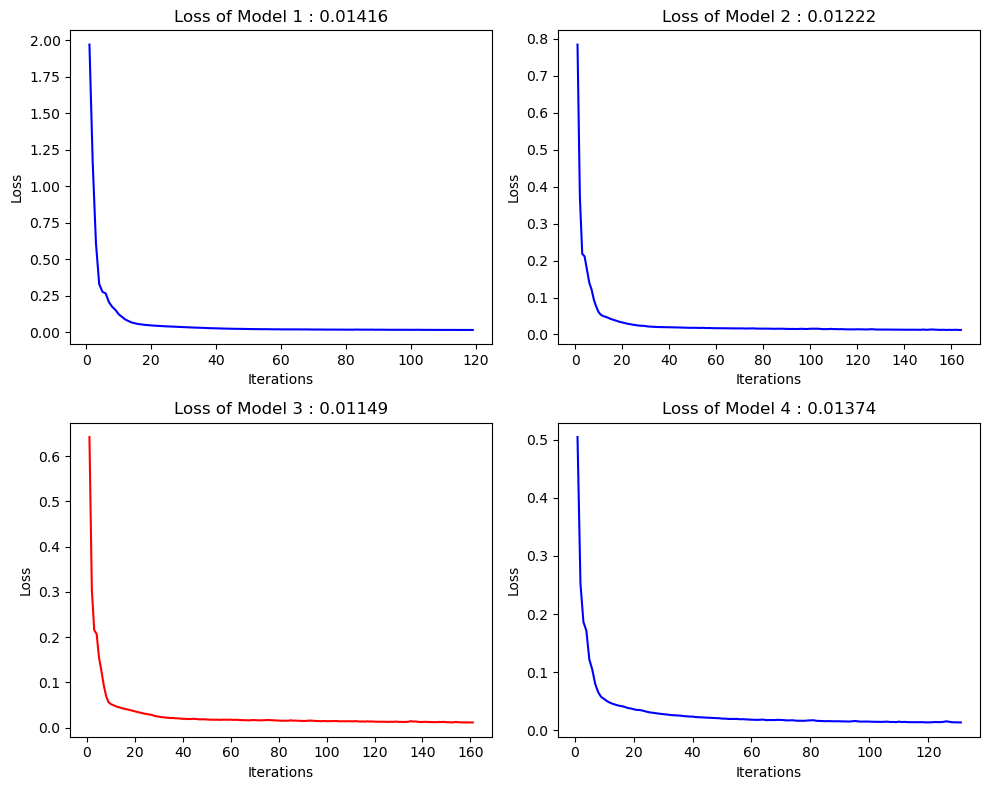

In [8]:
# performance on TRAINING set
if visual:
    plot_loss(ensemble_models, highlight = True)

Finding next experiments to test by active learning and save results in csv 

NOTE: Not yet able to change exploit/explore ratio

In [9]:
ucb_top, ratio, exploit_top, explore_top = active_found(ensemble_models, sampling_condition, nb_new_data, X, scaler, verbose = True)

For UCB:
Maximum yield prediction = 2.284253447135748
For exploitation:
Maximum yield prediction = 2.284253447135748
For exploration:
Maximum yield prediction = 1.8470565368504808


Plot histogram for exploit/ explore ratio

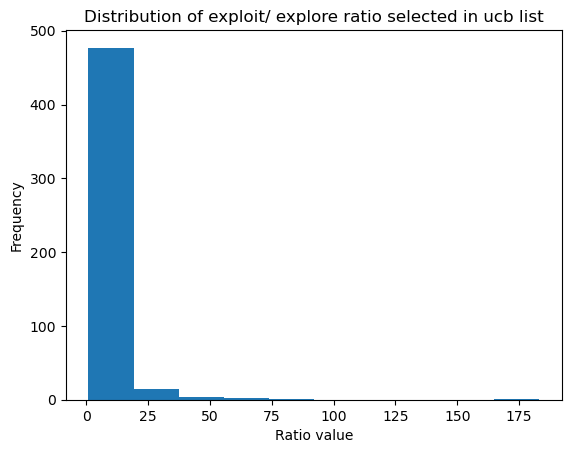

In [21]:
plt.hist(ratio)
plt.xlabel('Ratio value')
plt.ylabel('Frequency')
plt.title('Distribution of exploit/ explore ratio selected in ucb list')
plt.show()

# ratio calculated by exploitation / (ucb - exploitation)
# higher ratio , higher exploitation value
# ratio = 1, exploit = explore value

Save results as csv

In [11]:
# save file
np.savetxt(name + "_ucb.csv", ucb_top, delimiter=',', header=','.join(element_list), comments='')           # save X selected by ucb
np.savetxt(name + "_exeploit/explore_ratio.csv", )                                                          # save ratio in ucb list
np.savetxt(name + "_exploit.csv", exploit_top, delimiter=',', header=','.join(element_list), comments='')   # save X selected by exploitation 
np.savetxt(name + "_explore.csv", explore_top, delimiter=',', header=','.join(element_list), comments='')   # save X selected by exploration